# CO416 - Machine Learning for Imaging

## Tutorial 1 - Image processing with Python

In this tutorial, we will learn basics of image IO and simple processing, and visualisation in Python. 
If you want to refresh your python basics, please check this [tutorial](http://cs231n.github.io/python-numpy-tutorial/) from the computer vision course at Stanford.

By the end of the tutorial, you should be able to:
1. Use python, numpy, and run jupyter notebook
2. Build a simple binary classifier 
3. Implement a logistic regression classifier using numpy

---


In [1]:
# import common libraries
import numpy as np

# import some helper code
import sys
sys.path.append('code')
from mli import plot_digit, plot_digits

# adjust settings to plot nice figures inline
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# data directory
data_dir = '/vol/lab/course/416/data/mnist'


---

## ML Project Example - Image Classification

In a real ML task, data would be available in a database and organised in tables, documents or files. In this tutorial, we will be using the [MNIST dataset](http://yann.lecun.com/exdb/mnist/), small images of digits handwritten by high school students and employees of the US Census Bureau. It consists of a training set of 60,000 examples, and a test set of 10,000 examples. Each image is size-normalized and centered in a fixed-size image 28x28 pixels, and labeled with the digit it represents. It is kind of the *hello world* of machine learning for imaging. You can find more benchmark datasets [here](https://pytorch.org/docs/stable/torchvision/datasets.html)


Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: /vol/lab/course/416/data/mnist
    Transforms (if any): None
    Target Transforms (if any): None
Dataset MNIST
    Number of datapoints: 10000
    Split: test
    Root Location: /vol/lab/course/416/data/mnist
    Transforms (if any): None
    Target Transforms (if any): None


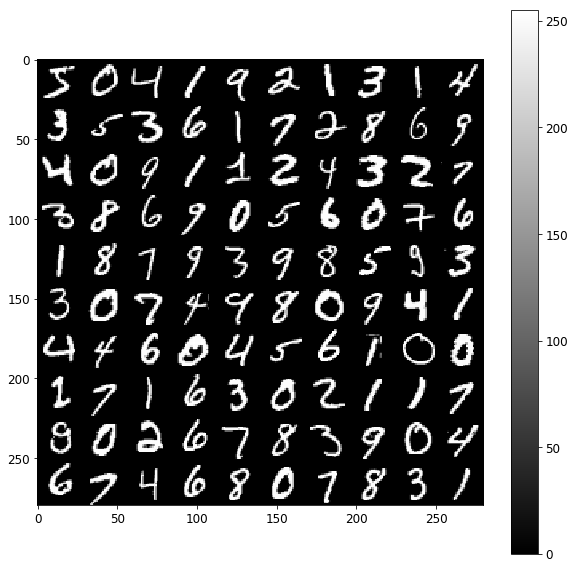

In [2]:
import torchvision.datasets as dset

# train data
train_set = dset.MNIST(root=data_dir, train=True, download=False)
train_data = np.array(train_set.train_data)
train_labels = np.array(train_set.train_labels)
# test data
test_set = dset.MNIST(root=data_dir, train=False, download=False)
test_data = np.array(test_set.test_data)
test_labels = np.array(test_set.test_labels)\

# print train and test data details
print(train_set)
print(test_set)

# plot sample digits
plot_digits(train_set.train_data[:100])
plt.show()

---
Here, we will sort our data and fix the random seed to ensure geting same results everytime you run the experiments. Then plot some sampled digits after sorting the data.

[    1    21    34 ... 59973 59990 59992]
[   3   10   13 ... 9945 9973 9992]


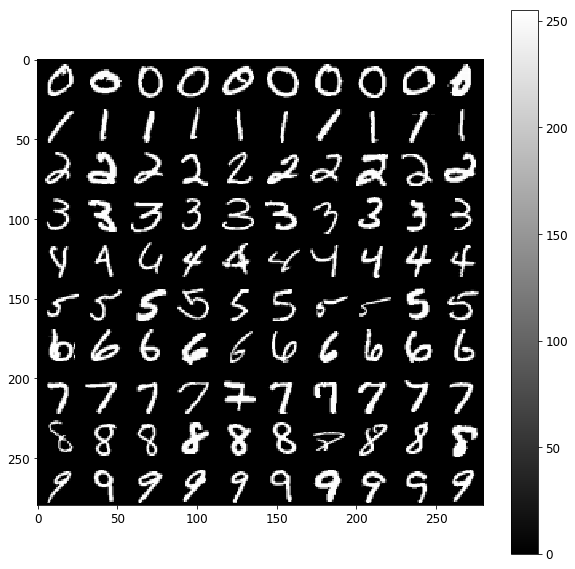

In [3]:
# we will sort our data and fix the random generator seed to get similar results from different runs
np.random.seed(42)

# sort dataset
def sort_data(data, labels):
#        print([(target, i) for i, target in enumerate(labels)])
#        print(sorted([(target, i) for i, target in enumerate(labels)]))
# [:,1], get the column(vertical)
        sorted_idxs = np.array(sorted([(target, i) for i, target in enumerate(labels)]))[:, 1]
        print(sorted_idxs)
        return data[sorted_idxs], labels[sorted_idxs]
#x = np.array([(0,0),(1,1)])
#print(x)
############################################################################
# Q: use the previous function to sort both training and testing data
############################################################################
train_data,train_labels = sort_data(train_data,train_labels)
test_data,test_labels = sort_data(test_data,test_labels)
############################################################################

# plot sampled images from sorted data
# here it samples 20 samples of [0,1], 30 samples of [2,3,4], and 50 samples of [5,6,7,8,9] - 10 samples for each digit
example_images = np.r_[train_data[:12000:600], train_data[13000:30600:600], train_data[30600:60000:590]]
plot_digits(example_images)
plt.show()

---
### Simple Binary Classifier

Now our data are cleaned and sorted, we will train a simple binary classifier to distinguish between two selected digits. 

Data usually is divided into three sets for training, validation, and testing. The training data is used to train the model's parameters, while the validation set is used to adjust the model's hyperparameters. Finally, the performance of the trained model is evaluated on the testing data. For this tutorial we will split the data into train and test for simplification. 

**Task - 01**

1. Extract ones and eights from both training and testing data
2. Shuffle training data
3. Plot number of images versus number of 'white' pixels per image
4. Can you predict the label based only on the number of 'white' pixels? What's the training and testing error for such an approach?

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


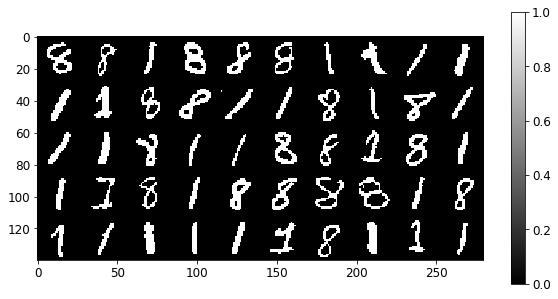

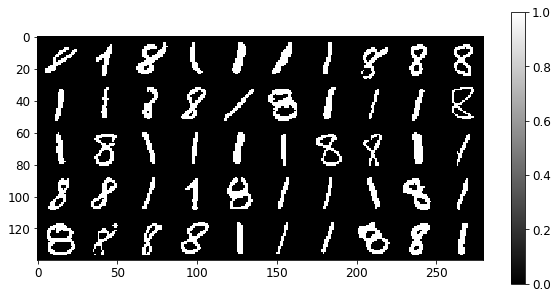

In [4]:
############################################################################
# Extract sample digits of ones and eights
############################################################################

def sample_data_digits(data, labels, labels_to_select):
    # convert input 3d arrays to 2d arrays
    nsamples, nx, ny = data.shape
    data_vec = np.reshape(data,(nsamples,nx*ny))
   
    selected_indexes = np.isin(labels, labels_to_select)
    selected_data = data_vec[selected_indexes]
    selected_labels = labels[selected_indexes]
    # Convert images from gray to binary by thresholding intensity values
    selected_data = 1.0 * (selected_data >= 128)

    # convert labels to binary: digit_1=False, digit_2=True
    selected_labels = selected_labels==labels_to_select[1]
    
    # shuffle data
    shuffle_index = np.random.permutation(len(selected_labels))
    selected_data, selected_labels = selected_data[shuffle_index], selected_labels[shuffle_index]

    return selected_data, selected_labels


############################################################################
# Q: extract ones and eights digits from both training and testing data 
############################################################################
labels_to_select = [1,8]
selected_train_data, selected_train_labels = sample_data_digits(train_data, train_labels, labels_to_select)
# print(selected_train_labels)
print(selected_train_data)
############################################################################

# plot sampled digits
plot_digits(selected_train_data[0:50])
plt.show()
plot_digits(selected_train_data[8000:8050])
plt.show()

[44 56 61 ... 68 67 64]


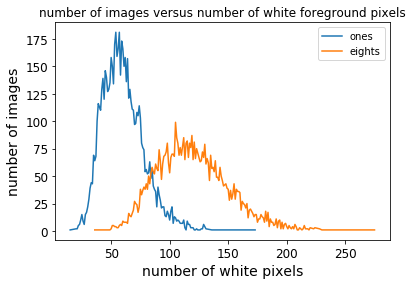

In [5]:
############################################################################
# Q:plot number of images versus number of 'white' foreground pixels 
# for both 1s and 8s classes
############################################################################
#for selected in selected_train_data
from collections import Counter
# get 1s and 8s
ones_data,ones_labels = sample_data_digits(train_data, train_labels, [1, 1])
eights_data,eights_labels = sample_data_digits(train_data, train_labels, [8, 8])

# count numbers of white pixels in each image
ones = np.count_nonzero(ones_data == 1, axis=1)
eights = np.count_nonzero(eights_data == 1, axis=1)
print(ones)
# count numbers of images with each number of white pixels
one = Counter(ones)
eight = Counter(eights)
sorted_one = sorted(one.items())
sorted_eight = sorted(eight.items())
# x: number of white pixels(ascending)
# y: number of images
onex = [i[0] for i in sorted_one]
oney = [i[1] for i in sorted_one]
eightx = [i[0] for i in sorted_eight]
eighty = [i[1] for i in sorted_eight]
plt.plot(onex, oney)
plt.plot(eightx, eighty)
plt.xlabel('number of white pixels')
plt.ylabel('number of images')
plt.title('number of images versus number of white foreground pixels')
plt.legend(['ones', 'eights'])
plt.show()  # You must call plt.show() to make graphics appear.selected_train_data

In [6]:
############################################################################
# Q: select threshold value to sperate between the two classes
############################################################################
threshold = 80

In [7]:
############################################################################
# Q: classify digits using a threshold 
############################################################################
# true = 8, false = 1
white = np.count_nonzero(selected_train_data == 1, axis=1)
index = [pixels>threshold for pixels in white]
print(index)

[True, False, False, True, True, True, False, True, False, True, True, True, True, True, False, False, True, False, True, False, True, True, True, False, False, True, False, True, True, False, False, False, False, False, True, True, True, True, False, True, False, False, True, False, False, True, True, True, False, False, True, True, True, True, False, True, False, False, False, False, True, True, False, True, True, False, True, True, False, True, False, False, False, True, True, True, True, True, True, False, False, True, False, False, True, True, False, True, False, False, False, True, True, False, False, True, False, True, True, True, True, True, True, True, False, True, True, False, True, True, False, False, False, True, False, False, False, False, True, True, False, False, True, False, True, True, False, False, True, False, True, False, True, True, True, True, False, True, False, False, False, False, True, True, True, False, False, False, False, False, True, True, True, False, Fal

In [8]:
############################################################################
# Q: calculate both training and testing accuracy
# You should get accuracies around 89-90%
############################################################################
# training accuracy
acc_train = (index == selected_train_labels).mean()
print('training accuracy is:')
print(acc_train)

selected_test_data, selected_test_labels = sample_data_digits(test_data, test_labels, labels_to_select)
white_test = np.count_nonzero(selected_test_data == 1, axis=1)
index_test = [pixels>threshold for pixels in white_test]
acc_test = (index_test == selected_test_labels).mean()
print('test accuracy is:')
print(acc_test)

training accuracy is:
0.8930358135472087
test accuracy is:
0.8999525841631105


---
**Task - 02**
Repeat the previous examples to classify digits 0s and 8s instead of 1s and 8s. Will the threshold binary classifier differentiate between the two categories based on number of 'white' pixels?

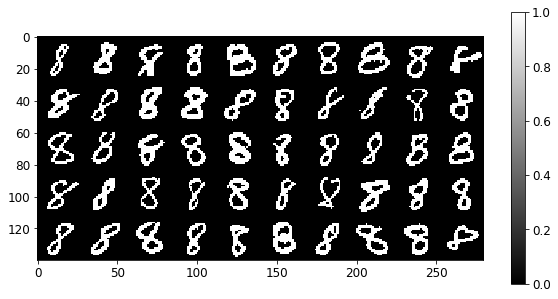

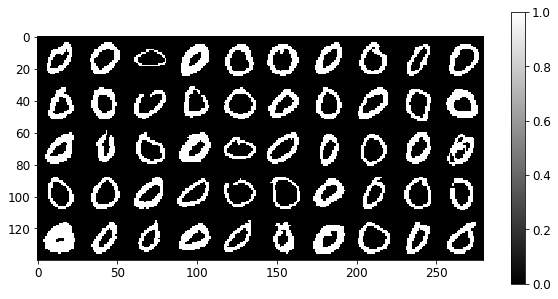

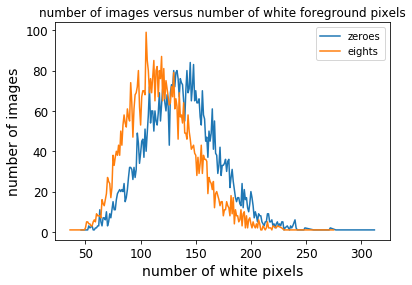

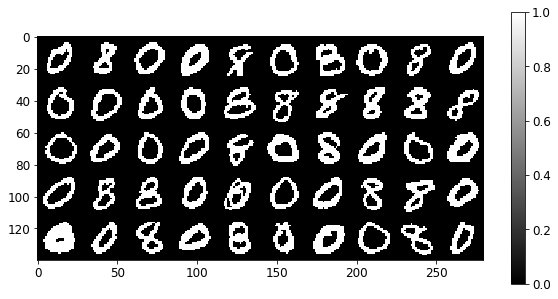

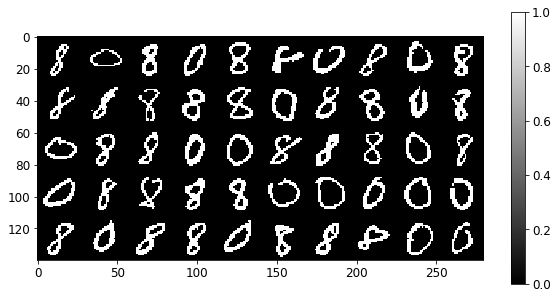

0.6195855274333276
0.33572159672466734


In [9]:
############################################################################
# Q: extract zeros and eights digits from both training and testing data(false = 0, true = 8)
############################################################################
labels_to_select0 = [0,8]
selected_train_data0, selected_train_labels0 = sample_data_digits(train_data, train_labels, labels_to_select0)

############################################################
# Q: plot number of images versus number of pixels
############################################################
################## 1:seperate 0s and 8s ####################
def seperate(data, label):
    #true = ind2; false = ind1
    indices_2 = [i for i, x in enumerate(label) if x]
    indices_1 = [i for i, x in enumerate(label) if x == 0]
    return data[indices_1,:], data[indices_2,:]
zero_data, eight_data = seperate(selected_train_data0, selected_train_labels0)
plot_digits(eight_data[0:50])
plt.show()
plot_digits(zero_data[0:50])
plt.show()
################## 2:count white pixels ####################
w_0 = (zero_data == 1).sum(axis=1)
x_0 = np.array(sorted([[x,np.count_nonzero(w_0 == x)] for x in set(w_0)]))[:,0]
y_0 = np.array(sorted([[x,np.count_nonzero(w_0 == x)] for x in set(w_0)]))[:,1]

w_8 = (eight_data == 1).sum(axis=1)
x_8 = np.array(sorted([[x,np.count_nonzero(w_8 == x)] for x in set(w_8)]))[:,0]
y_8 = np.array(sorted([[x,np.count_nonzero(w_8 == x)] for x in set(w_8)]))[:,1]

####################### 3:plot part #########################
plt.plot(x_0, y_0)
plt.plot(x_8, y_8)
plt.xlabel('number of white pixels')
plt.ylabel('number of images')
plt.title('number of images versus number of white foreground pixels')
plt.legend(['zeroes', 'eights'])
#plt.show()  # You must call plt.show() to make graphics appear.selected_train_data

################# 3:threshold classifer #####################
thresh = 130
w_08 = (selected_train_data0 == 1).sum(axis=1)
indices_0 = [i for i,x in enumerate(w_08) if x>thresh]
indices_8 = [i for i,x in enumerate(w_08) if x<=thresh]
clssify_0 = selected_train_data0[indices_0,:]
clssify_8 = selected_train_data0[indices_8,:]
plot_digits(clssify_0[0:50])
plt.show()
plot_digits(clssify_8[0:50])
plt.show()

################# 4:classifier accuracy #####################

#4.1 test accuracy
class_labels_train = np.array([None] * selected_train_labels0.size)
#print(selected_train_labels0.size)
class_labels_train[indices_0] = False
class_labels_train[indices_8] = True
acc_train = (class_labels_train ==  selected_train_labels0).mean()
#print(class_labels)
#print(selected_train_labels0)
#print(indices_0)
print(acc_train)

#4.2 train accuracy
selected_test_data0, selected_test_labels0 = sample_data_digits(test_data, test_labels, labels_to_select0)
zero_data, eight_data = seperate(selected_train_data0, selected_train_labels0)

w_08_test = (selected_test_data0 == 1).sum(axis=1)
indices_0_test = [i for i,x in enumerate(w_08_test) if x<thresh]
indices_8_test = [i for i,x in enumerate(w_08_test) if x<=thresh]
clssify_0_test = selected_test_data0[indices_0_test,:]
clssify_8_test = selected_test_data0[indices_8_test,:]

class_labels_test = np.array([None] * selected_test_labels0.size)
class_labels_test[indices_0_test] = False
class_labels_test[indices_8_test] = True
acc_test = (class_labels_test ==  selected_test_labels0).mean()
print(acc_test)

---
## Logistic Regression using Numpy

In the previous example, we used a simple threshold to classify each image of a digit using one feature (number of 'white' pixels). Here, we will use a logistic regression model for this task. The logistic regression function is defined as: $h_{\Theta}(\mathbf{x}) =  \frac{1}{1 + \exp(-\theta^{\top} \mathbf{x})}$.

Training our model is a loop that includes three main steps
1. Evaluate the cost function $J(\Theta)$
2. Compute partial derivatives
3. Update the model paramteters

Details can be found in slides 24-34, of Lecture 2.

---

**Task - 03**

1. Complete the logistic regression class below 
2. Train a logistic regression model on the data from the previous example
3. Compute train and test accuracies, and compare with the previous results
4. Plot the trained parameters and comment on the figure

In [10]:
class LogisticRegression:
    def __init__(self, lr=0.05, num_iter=1000, add_bias=True, verbose=True):
        self.lr = lr
        self.verbose = verbose
        self.num_iter = num_iter
        self.add_bias = add_bias
    
    def __add_bias(self, X):
        bias = np.ones((X.shape[0], 1))
        return np.concatenate((bias, X), axis=1)
    


    def __loss(self, h, y):
        ''' computes loss values '''
        y = np.array(y,dtype=float)
        ############################################################################
        # Q: compute the loss 
        ############################################################################
        eps=1e-10
        J1 = (-1.0) * np.multiply(y, np.log(h + eps))
        J0 = (-1.0) * np.multiply(1.0 - y, np.log(1.0 - h + eps))
        J = np.mean(J0 + J1, axis = 1)
        return J
    
    def fit(self, X, y):
        ''' 
        Optimise our model using gradient descent
        Arguments:
            X input features
            y labels from training data
            
        '''
        if self.add_bias:
            X = self.__add_bias(X)
                                  
        ############################################################################
        # Q: initialise weights randomly with normal distribution N(0,1)
        ############################################################################
        w = np.random.normal(size = X_train.shape[0])
        
        for i in range(self.num_iter):
            ############################################################################
            # Q: forward propagation
            ############################################################################
            Z= np.matmul(w.T, X)
            A = 1.0/(1.0 + np.exp(-1.0 * Z))
            ############################################################################
            # Q: backward propagation
            ############################################################################
            dw = np.matmul(X, np.transpose(A - Y)) * (1.0/m)  
            # update parameters
            learning_rate = 0.01
            w = w - learning_rate * dw
            ############################################################################
            # Q: print loss
            ############################################################################
            if(self.verbose == True and i % 50 == 0):
                print('loss is:')
                print(__loss(h, y))
        return w
    
    def predict_probs(self,X):
        ''' returns output probabilities
        '''
        ############################################################################
        # Q: forward propagation
        ############################################################################
        pass
        
    def predict_class(self, X, threshold=0.5):
        ''' returns output classes
        '''
        return self.predict_probs(X) >= threshold
    


In [21]:
X = np.random.normal(size = 5)
print(X)

[-0.48458647  1.13001001  0.65822265 -0.1451566  -1.27407946]


In [ ]:
#########################################################################
# Q: train our model
#########################################################################
pass

In [ ]:
#########################################################################
# Q: Evaluate the trained model - compute train and test accuracies
# You should get accuracies around 95%
#########################################################################
pass


In [ ]:
#########################################################################
# Q: plot trained model params (weights) as an image of size (28x28)
#########################################################################
pass


---
#### Bonus
- Plot both train and test error during training. How's this plot related to the variance/bias trade off? Over- and under-fitting?
- Apply the logistic regression classifier on all digits (multi-class). Comment on the results.
